In [1]:
from spacepy import pycdf
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

In [8]:
limit = 100000 # latch to this many CDF files for testing. Each CDF is a day of champ data.
champ_root_dir = "/Users/patrick/Dev/perceptive_techeval/data/champ-2002-2007/"

df_arr = []
processed = 0
for root, dirs, files in os.walk(os.path.abspath(champ_root_dir)):
    for file in [os.path.join(root, f) for f in files[0:limit] if f.endswith(".cdf")]:
        cdf = pycdf.CDF(file)
        alt = cdf["altitude"][:]/1000.0
        lat = cdf["latitude"][:]
        lon = cdf["longitude"][:]
        lst = cdf["local_solar_time"][:]
        valid = cdf["validity_flag"][:]
        density = cdf["density"][:]
        density_orbitmean = cdf["density_orbitmean"][:]
        time = cdf["time"][:]

        unix_timestamps = [dt.timestamp() for dt in time]
        density[density > 1e30] = np.nan # 1e30 is a stand-in for nan for these data. 
        delta_density = cdf["density"][:] - cdf["density_orbitmean"][:]

        df_arr.append(pl.DataFrame({"timestamp": unix_timestamps, "altitude":alt, "latitude":lat, "longitude":lon, "local_solar_time":lst, "validity_flag":valid, "density_orbitmean":density_orbitmean,"density":density, "delta_density":delta_density}))
        
        processed += 1 
        if processed >= limit:
            break
        
df = pl.concat(df_arr)

In [ ]:
df

In [11]:
# try something really simple first.

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10
random_seed = 123

X = np.array(df["altitude","latitude","longitude","local_solar_time"])
y = np.array(df["delta_density"])

mask = (~df["density"].is_null()) & (df["validity_flag"] == 0)
X = df.filter(mask).select(["altitude", "latitude", "longitude", "local_solar_time"]).to_numpy()
y = df.filter(mask)["delta_density"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=random_seed) # train, test, validation splits
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=random_seed) 

pipeline = make_pipeline(StandardScaler(),
                         SGDRegressor(max_iter=1000, tol=1e-3, random_state=random_seed))
param_grid = {
    "sgdregressor__alpha": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=random_seed), scoring="neg_mean_squared_error", verbose=2, n_jobs=4)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_["sgdregressor__alpha"]

print("best alpha: " + str(best_alpha))

Fitting 5 folds for each of 11 candidates, totalling 55 fits


KeyboardInterrupt: 

Mean Squared Error (MSE): 3.235075886767773e-24
Mean Absolute Error (MAE): 1.4621568971585632e-12
R² Score: 0.23940483279739277


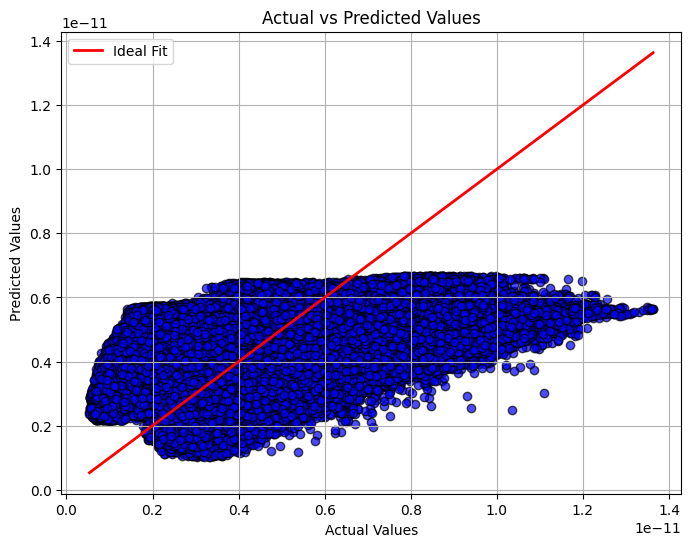

In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
best_model = pipeline.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10
random_seed = 123

X = np.array(df["altitude","latitude","longitude","local_solar_time"])
y = np.array(df["density"])

mask = (~df["density"].is_null()) & (df["validity_flag"] == 0)
X = df.filter(mask).select(["altitude", "latitude", "longitude", "local_solar_time"]).to_numpy()
y = df.filter(mask)["density"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=random_seed) # train, test, validation splits
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=random_seed) 

pipeline = make_pipeline(StandardScaler(),
                         XGBRegressor(random_state=random_seed))

param_grid = {
    'xgbregressor__n_estimators': [100, 200],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=random_seed), scoring="neg_mean_squared_error", verbose=2, n_jobs=4)
pipeline.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=123, ...))])

Mean Squared Error (MSE): 2.389165279556491e-24
Mean Absolute Error (MAE): 1.1200237983809136e-12
R² Score: -5.533057789719464e-09


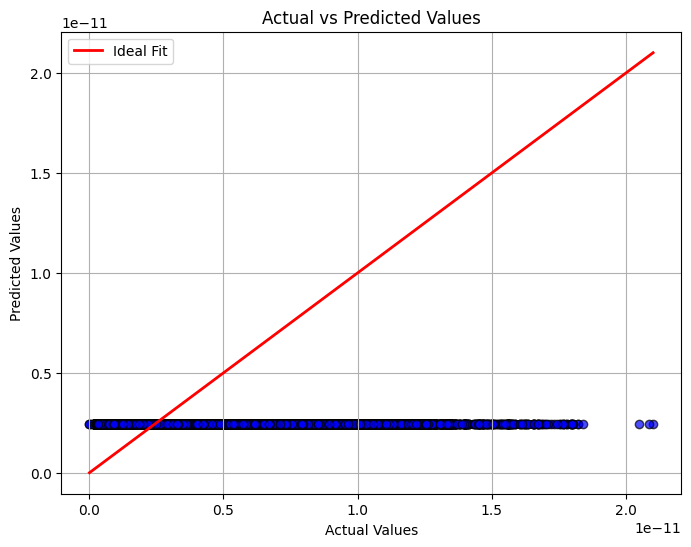

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


best_model = pipeline.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()